In [ ]:
!pip install numpy matplotlib scipy

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from numpy import pi, cos, sin, exp

In [ ]:

c = 343
f = 1000
omega = 2 * np.pi * f
lam = c / f
delta = 0.05
M = 3
theta = np.linspace(-np.pi/2, np.pi/2, 361)

print(f"Wavelength = {lam:.3f} m")
print(f"Element spacing = {delta} m")
print(f"Number of sensors = {M}")

Wavelength = 0.343 m
Element spacing = 0.05 m
Number of sensors = 3


In [ ]:


def steering_vector(omega, theta, delta, M, c):
    """Compute steering vector for a linear AVS array."""
    tau = delta / c
    d = np.exp(-1j * omega * tau * np.arange(M) * np.cos(theta))
    return d

def avs_response(theta):
    """AVS response Φ(θ) = [1, cosθ, sinθ]."""
    return np.array([1, np.cos(theta), np.sin(theta)])


theta_test = np.deg2rad(30)
d_test = steering_vector(omega, theta_test, delta, M, c)
phi_test = avs_response(theta_test)

print("Steering vector (θ=30°):", np.round(d_test, 3))
print("AVS response Φ(θ):", np.round(phi_test, 3))


Steering vector (θ=30°): [ 1.   +0.j     0.702-0.713j -0.016-1.j   ]
AVS response Φ(θ): [1.    0.866 0.5  ]


In [ ]:


def avs_steering_matrix(omega, theta, delta, M, c):
    """Compute AVS-based steering matrix Φ(θ) ⊗ d(ω,θ)."""
    phi = avs_response(theta)
    d = steering_vector(omega, theta, delta, M, c)

    D = np.kron(phi, d)
    return D


D_test = avs_steering_matrix(omega, np.deg2rad(30), delta, M, c)
print("AVS steering matrix shape:", D_test.shape)
print("First few entries:", np.round(D_test[:6], 3))


AVS steering matrix shape: (9,)
First few entries: [ 1.   +0.j     0.702-0.713j -0.016-1.j     0.866+0.j     0.608-0.617j
 -0.014-0.866j]


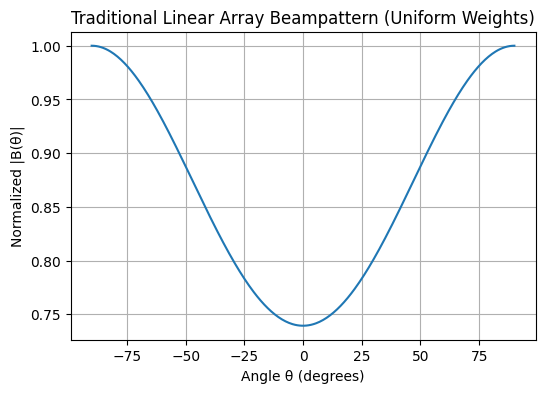

In [ ]:

def beampattern_uniform(omega, delta, M, c, theta_scan):
    """Compute normalized beampattern for a linear AVS array."""
    w = np.ones(M) / M
    B = []
    for th in theta_scan:
        d = steering_vector(omega, th, delta, M, c)
        B.append(np.abs(np.conj(w) @ d))
    B = np.array(B)
    B = B / np.max(B)
    return B


B_uniform = beampattern_uniform(omega, delta, M, c, theta)

plt.figure(figsize=(6,4))
plt.plot(np.rad2deg(theta), B_uniform)
plt.title("Traditional Linear Array Beampattern (Uniform Weights)")
plt.xlabel("Angle θ (degrees)")
plt.ylabel("Normalized |B(θ)|")
plt.grid(True)
plt.show()


In [ ]:

def compute_DF(B, theta):
    """DF = (|B(θ_d)|²) / (average |B(θ)|² over all θ)."""
    num = np.abs(B[np.argmax(B)])**2
    den, _ = quad(lambda th: np.abs(np.interp(th, theta, B))**2, theta[0], theta[-1])
    DF = num / (den / (theta[-1] - theta[0]))
    return DF

DF_uniform = compute_DF(B_uniform, theta)
print(f"Directivity Factor (Uniform Weights) = {DF_uniform:.3f}")


Directivity Factor (Uniform Weights) = 1.314


/tmp/ipython-input-3368206910.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  den, _ = quad(lambda th: np.abs(np.interp(th, theta, B))**2, theta[0], theta[-1])


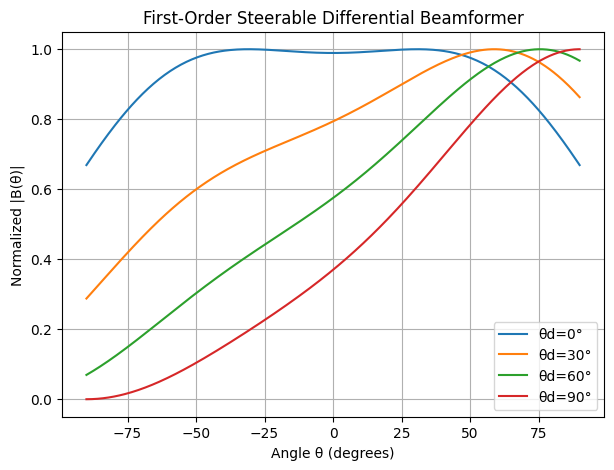

In [ ]:
)

def first_order_weights(theta_d):
    a10 = 1
    a11 = np.cos(theta_d)
    a12 = np.sin(theta_d)
    return a10, a11, a12

def beampattern_first_order(theta_scan, theta_d, omega, delta, M, c):
    a10, a11, a12 = first_order_weights(theta_d)
    B = []
    for th in theta_scan:
        d = steering_vector(omega, th, delta, M, c)
        phi = avs_response(th)

        w = a10 * phi[0] + a11 * phi[1] + a12 * phi[2]
        B.append(np.abs(np.sum(w * d)))
    B = np.array(B)
    return B / np.max(B)


angles_d = [0, 30, 60, 90]
plt.figure(figsize=(7,5))
for ad in angles_d:
    B1 = beampattern_first_order(theta, np.deg2rad(ad), omega, delta, M, c)
    plt.plot(np.rad2deg(theta), B1, label=f"θd={ad}°")

plt.title("First-Order Steerable Differential Beamformer")
plt.xlabel("Angle θ (degrees)")
plt.ylabel("Normalized |B(θ)|")
plt.legend()
plt.grid(True)
plt.show()


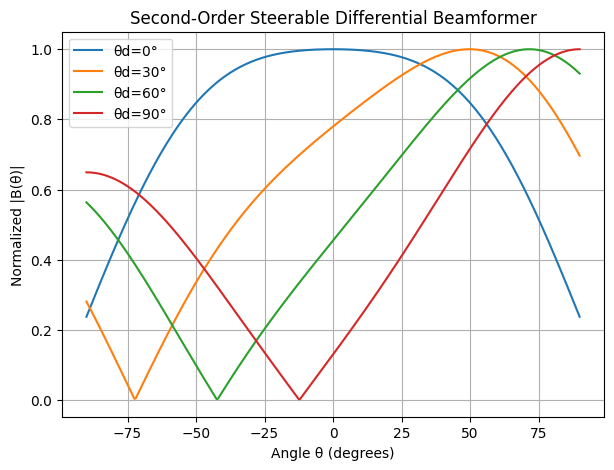

In [ ]:


def second_order_weights(theta_d):
    """Compute second-order coefficients (Eq. 36–38)."""
    a20 = 0.103
    a21 = 0.484
    a22 = 0.413

    a21s = a21 * np.cos(theta_d)
    a22s = a21 * np.sin(theta_d)
    return a20, a21s, a22s

def beampattern_second_order(theta_scan, theta_d, omega, delta, M, c):
    a20, a21, a22 = second_order_weights(theta_d)
    B = []
    for th in theta_scan:
        d = steering_vector(omega, th, delta, M, c)
        phi = avs_response(th)
        w = a20 * phi[0] + a21 * phi[1] + a22 * phi[2]
        B.append(np.abs(np.sum(w * d)))
    B = np.array(B)
    return B / np.max(B)


angles_d = [0, 30, 60, 90]
plt.figure(figsize=(7,5))
for ad in angles_d:
    B2 = beampattern_second_order(theta, np.deg2rad(ad), omega, delta, M, c)
    plt.plot(np.rad2deg(theta), B2, label=f"θd={ad}°")

plt.title("Second-Order Steerable Differential Beamformer")
plt.xlabel("Angle θ (degrees)")
plt.ylabel("Normalized |B(θ)|")
plt.legend()
plt.grid(True)
plt.show()


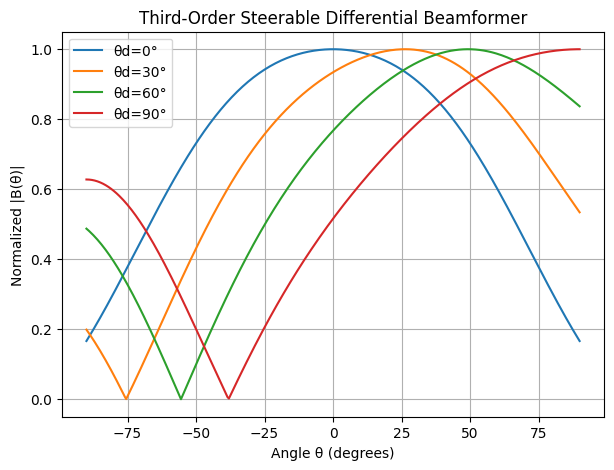

In [ ]:
def third_order_weights(theta_d):
    """Approximate third-order coefficients (Eq. 41–42, using normalized form)."""
    a30 = 0.08
    a31 = 0.35 * np.cos(theta_d)
    a32 = 0.35 * np.sin(theta_d)
    a33 = 0.22
    return a30, a31, a32, a33

def beampattern_third_order(theta_scan, theta_d, omega, delta, M, c):
    a30, a31, a32, a33 = third_order_weights(theta_d)
    B = []
    for th in theta_scan:
        d = steering_vector(omega, th, delta, M, c)
        phi = avs_response(th)
        w = a30 * phi[0] + a31 * phi[1] + a32 * phi[2] + a33 * (phi[1]**2)
        B.append(np.abs(np.sum(w * d)))
    B = np.array(B)
    return B / np.max(B)


angles_d = [0, 30, 60, 90]
plt.figure(figsize=(7,5))
for ad in angles_d:
    B3 = beampattern_third_order(theta, np.deg2rad(ad), omega, delta, M, c)
    plt.plot(np.rad2deg(theta), B3, label=f"θd={ad}°")

plt.title("Third-Order Steerable Differential Beamformer")
plt.xlabel("Angle θ (degrees)")
plt.ylabel("Normalized |B(θ)|")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-3368206910.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  den, _ = quad(lambda th: np.abs(np.interp(th, theta, B))**2, theta[0], theta[-1])


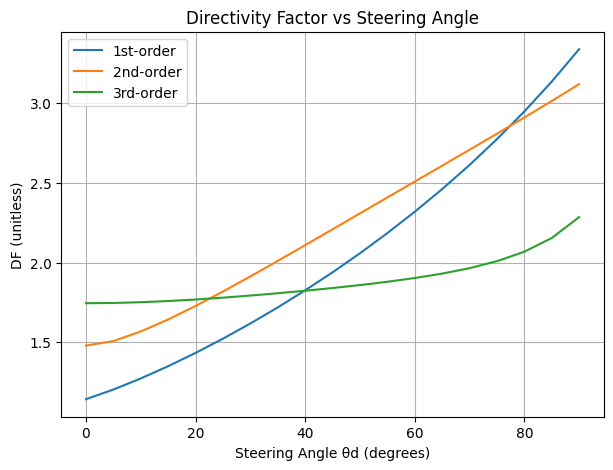

In [ ]:
def DF_vs_angle(order_fn, order_name):
    thetas_d = np.deg2rad(np.arange(0, 91, 5))
    DFs = []
    for td in thetas_d:
        B = order_fn(theta, td, omega, delta, M, c)
        DF = compute_DF(B, theta)
        DFs.append(DF)
    plt.plot(np.rad2deg(thetas_d), DFs, label=f"{order_name}-order")

plt.figure(figsize=(7,5))
DF_vs_angle(beampattern_first_order, "1st")
DF_vs_angle(beampattern_second_order, "2nd")
DF_vs_angle(beampattern_third_order, "3rd")
plt.title("Directivity Factor vs Steering Angle")
plt.xlabel("Steering Angle θd (degrees)")
plt.ylabel("DF (unitless)")
plt.legend()
plt.grid(True)
plt.show()


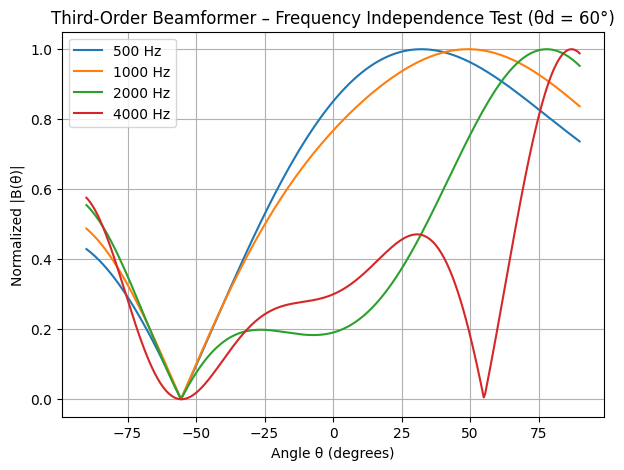

In [ ]:
freqs = np.array([500, 1000, 2000, 4000])  # Hz
theta_d = np.deg2rad(60)

plt.figure(figsize=(7,5))
for f in freqs:
    omega = 2 * np.pi * f
    Bf = beampattern_third_order(theta, theta_d, omega, delta, M, c)
    plt.plot(np.rad2deg(theta), Bf, label=f"{f} Hz")

plt.title("Third-Order Beamformer – Frequency Independence Test (θd = 60°)")
plt.xlabel("Angle θ (degrees)")
plt.ylabel("Normalized |B(θ)|")
plt.legend()
plt.grid(True)
plt.show()
